<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/4_Second_order_methods/4_4_Newtons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 4: Second order methods

# Newton's Method

Since the first order Taylor series approximation to a function leads to the local optimization framework of gradient descent, it seems intuitive that higher order Taylor series approximations might similarly yield descent-based algorithms as well.  In this Section we introduce a local optimization scheme based on the second order Taylor series approximation - called *Newton's method*.  Because it is based on the second order approximation Newton's method has natural strengths and weaknesses when compared to gradient descent.  In summary we will see that the cumulative effect of these trade-offs is - in general - that Newton's method is especially useful for minimizing convex functions of a moderate number of inputs.

In [1]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone library subdirectory
    if not Path('chapter_4_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/4_Second_order_methods/chapter_4_library
    else:
        print('chapter_4_library already cloned!')

    # clone images
    if not Path('chapter_4_images').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/4_Second_order_methods/chapter_4_images
    else:
        print('chapter_4_images already cloned!')

    # clone videos
    if not Path('chapter_4_videos').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/4_Second_order_methods/chapter_4_videos
    else:
        print('chapter_4_videos already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_4_library')
sys.path.append('./chapter_4_images') 
sys.path.append('./chapter_4_videos') 

# import section helper
import section_4_4_helpers

# image paths
image_path_1 = 'chapter_4_images/Fig_2_11.png'

# video paths
video_path_1 = 'chapter_4_videos/animation_5.mp4'
video_path_2 = 'chapter_4_videos/animation_6.mp4'
video_path_3 = 'chapter_4_videos/animation_7.mp4'
video_path_4 = 'chapter_4_videos/animation_8.mp4'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=566e97b0a374cc9cf08f588bb7e21d2e24505967e7767d5f5b3d46f50ea86cd8
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
Cloning into 'chapter_4_library'...
done.
Cloning into 'chapter_4_images'...
done.
Cloning into 'chapter_4_videos'...
done.


##  The descent direction provided by second order Taylor series approximation

The second order Taylor series approximation of a single input functions $g(w)$ at a particular point $v$ is a quadratic function of the form

\begin{equation}
h(w) = g(v) + \left(\frac{\mathrm{d}}{\mathrm{d}w}g(v)\right)(w - v) +  \frac{1}{2}\left(\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(v)\right)(w - v)^2
\end{equation}

which is - typically speaking - a much better approximation of the underlying function near $v$ than is the first order Taylor series approximation on which gradient descent is built.

#### <span style="color:#a50e3e;">Example 1. </span>  Single input Taylor series of a sinusoid

Below we produce an animation visualizing a single-input function $g(w) = \text{sin}(2w)$, along with its first and second order Taylor series approximation.  As the animation plays the point $v$ (shown as a red dot) on which the approximations is based moves left to right, producing new approximations (the point on the graph of $g$ at which the approximations are tangent is marked with a small red 'x').  One can see that at each point the second order approximation (in blue) - since it contains both first and second derivative information at the point - is a much better local approximator than the first order analog (in green). 

Note how the second order approximation matches the local convexity/concavity of the function $g$, i.e., where $g$ is convex/concave so too is the quadratic approximation.  

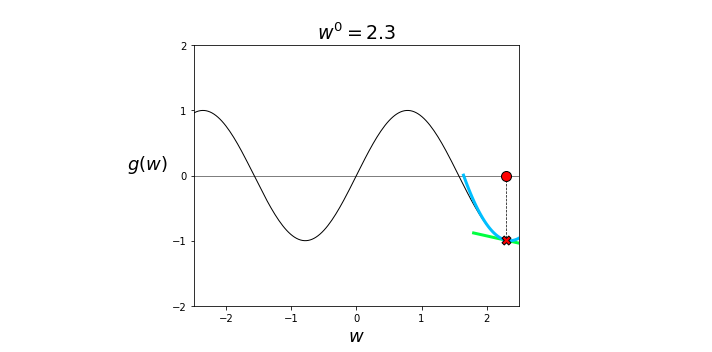

In [2]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.sin(2*w)

# create an instance of the visualizer with this function 
taylor_viz = section_4_4_helpers.taylor_2d_visualizer(g = g)

# run the visualizer for our chosen input function
taylor_viz.draw_it(savepath=video_path_1,first_order = True,second_order = True,num_frames = 200,fps=20)

In [3]:
show_video(video_path_1, width=800)

---

This natural quadratic approximation generalizes for functions $g(\mathbf{w})$ taking in $N$ inputs, where at a point $\mathbf{v}$ the analogous second order Taylor series approximation looks like

\begin{equation}
h(\mathbf{w}) = g(\mathbf{v}) + \nabla g(\mathbf{v})^T(\mathbf{w} - \mathbf{v}) + \frac{1}{2}(\mathbf{w} - \mathbf{v})^T \nabla^2 g\left(\mathbf{v}\right) (\mathbf{w} - \mathbf{v})
\end{equation}

where $\nabla g(\mathbf{v})$ is the *gradient* vector of first order partial derivatives, and $\nabla^2 g(\mathbf{v})$ is the $N\times N$ *Hessian* matrix containing second order partial derivatives of $g$ at $\mathbf{v}$.  Like the analogous single-input version, this quadratic is a much better local approximator of $g$ near the point $\mathbf{v}$, matching its convexity/concavity there (i.e., if $g$ is convex/concave at $\mathbf{v}$ so too is the second order approximation).

#### <span style="color:#a50e3e;">Example 2. </span>  Multi-input Taylor series of a sinusoid

Below we show an example comparing first and second order approximations (in green and blue respectively) using the sinusoid $g(w_1,w_2) = \text{sin}\left(w_1\right)$ at the point $\mathbf{v} = \begin{bmatrix} -1.5 \\ 1 \end{bmatrix}$.  Clearly the second order approximation provides a better local representation of the function here.

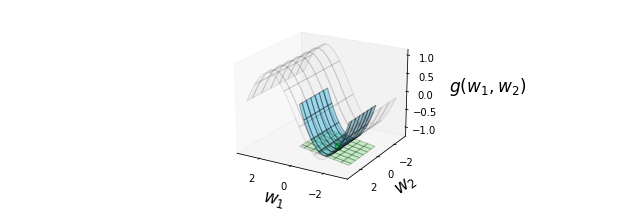

In [6]:
# create a function and point to compute approximation
g = lambda w: np.sin(w[0])
w_val = [-1.5,1]
view = [20,120]

# load in function to examine
viz = section_4_4_helpers.taylor_3d_visualizer(g = g)

# start examination
viz.draw_it(w_val = w_val,view = view,first_order = True, second_order = True);

----

In analogy to gradient descent, what would it mean to move in the 'descent direction' defined by the second order approximation at $\mathbf{v}$?  Well unlike a hyperplane, a quadratic does not itself have such a descent direction.  However it does have *stationary points* which are global minima when the quadratic is *convex*.  Like the descent direction of a hyperplane, we can actually compute the stationary point(s) fairly easily using the first order condition for optimality (described in [Section 3.2](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_2_First.html)).

For the single input case of the second order Taylor series approximation centered at a point $v$ we can solve for the stationary point of the quadratic approximation by setting the first derivative of $h(w)$ to zero and solving.  Doing this we compute the point $w^{\star}$

\begin{equation}
w^{\star} = v - \frac{\frac{\mathrm{d}}{\mathrm{d}w}g(v)}{\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(v)}
\end{equation}

Note that this update says that to get to the point $w^{\star}$ we move from $v$ in the direction given by $- \frac{\frac{\mathrm{d}}{\mathrm{d}w}g(v)}{\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(v)}$. 

The same kind of calculation can be made in the multi-input case.  Setting the gradient of the quadratic approximation to zero and solving gives the stationary point $\mathbf{w}^{\star}$ where

\begin{equation}
\mathbf{w}^{\star} = \mathbf{v} - \left(\nabla^2 g(\mathbf{v})\right)^{-1}\nabla g(\mathbf{v})
\end{equation}

This is the direct analog of the single-input solution, and indeed reduces to it when $N=1$.  It likewise says that in order to get to the new point $\mathbf{w}^{\star}$ we move from $\mathbf{v}$ in the direction $- \left(\nabla^2 g(\mathbf{v})\right)^{-1}\nabla g(\mathbf{v})$.

So in this notation, what might happen if we have a general function $g(\mathbf{w})$ and at the point $\mathbf{v}$ we form the second order Taylor series approximation there, calculate a stationary point $\mathbf{w}^{\star}$ of this quadratic, and move to it from $\mathbf{v}$?  When might this lead us to a lower point on $g$?  In other words, when might $- \left(\nabla^2 g(\mathbf{v})\right)^{-1}\nabla g(\mathbf{v})$ be a descent direction?  Let us examine a few examples to build up our intuition.

#### <span style="color:#a50e3e;">Example 3. </span>  Studying where the stationary point of the approximating quadratic leads on several convex functions

Below we illustrate this idea for the function

\begin{equation}
g(w) = \frac{1}{50}\left(w^4 + w^2\right) + 0.5
\end{equation}

Beginning at an input point $v$ (shown as a red circle) we draw the second order Taylor series (in light blue) for the above function at this input, marking the point on the graph of $g$ where it is tangent as a red X.  We mark the stationary point $w^{\star}$ of our quadratic along the input axis with a green circle, marking the evaluation of both the quadratic and original function at this point with a dark and green X's respectively.  The animation moves the input point across the input domain of the function, and everything is re-computed and drawn.

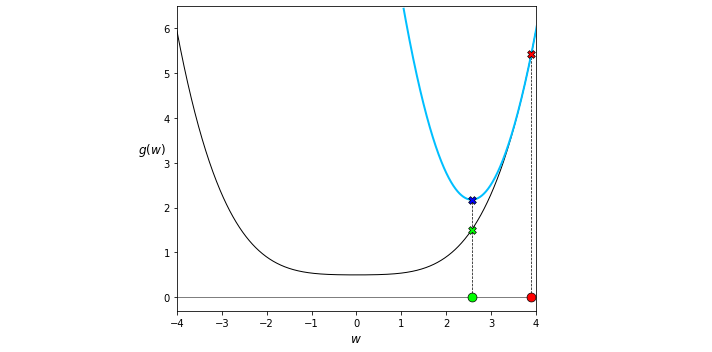

In [7]:
# choose your function
g = lambda w: 1/float(50)*(w**4 + w**2) + 0.5 

# run the visualizer for our chosen input function and number of frames
demo = section_4_4_helpers.majorizer_visualizer(g=g);
demo.animate_it(savepath=video_path_2,num_frames = 200,max_val = 4,fps=20)

In [4]:
show_video(video_path_2, width=800)

Moving the animation slider back and forth we can note that - because $g(w)$ is convex - the quadratic approximation is always convex and facing upward, hence its stationary point is a global minimum (of the quadratic).  In this particular instance it appears that the minimum of the quadratic approximation $w^{\star}$ always leads to a lower point of the function than where we begin at $v$.  

#### <span style="color:#a50e3e;">Example 4. </span>  Studying where the stationary point of the approximating quadratic leads on a sinusoid

Below we illustrate this idea for the function

\begin{equation}
g(w) = \text{sin}(3w) + 0.1w^2 + 1.5
\end{equation}

using the same visualization scheme and slider widget as in the previous example.

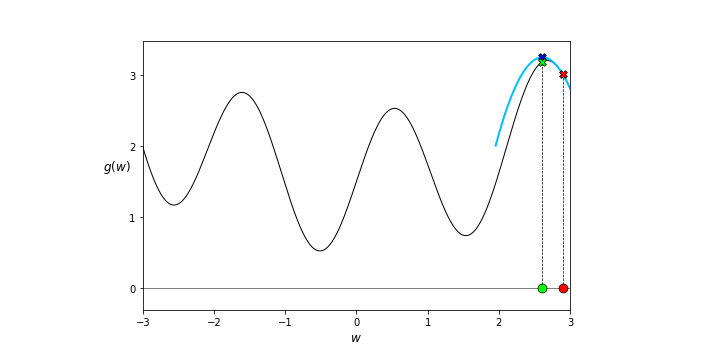

In [11]:
# choose your function
g = lambda w: np.sin(3*w) + 0.1*w**2 + 1.5

# run the visualizer for our chosen input function and number of frames
demo = section_4_4_helpers.majorizer_visualizer(g=g);
demo.animate_it(savepath=video_path_3,num_frames = 200,max_val = 3,fps=20)

In [14]:
show_video(video_path_3, width=800)

Here the situation is clearly different, with non-convexity being the culprit.  In particular at concave portions of the function - since here the quadratic is also concave - the stationary point of the quadratic approximation is a global minimum of the approximator, and tending to lead us towards points that *increase* the value of the function (not *decrease* it).

---

From our cursory investigation of a few simple examples we can intuit that this idea - repeatedly traveling to points defined by the stationary point of the second order Taylor series approximation - could produce a powerful algorithm for minimizing *convex* functions.  This is indeed the case, and the resulting idea is called the *Newton's method* algorithm.

##   Newton's method

Newton's method is the local optimization algorithm produced by repeatedly taking steps that are stationary points of the second order Taylor series approximations to a function. Repeatedly iterating in this manner, at the $k^{th}$ step we move to the stationary point of the quadratic approximation generated at the previous step $\mathbf{w}^{k-1}$ which is given as

\begin{equation}
h(\mathbf{w}) = g(\mathbf{w}^{k-1}) + \nabla g(\mathbf{w}^{k-1})^T(\mathbf{w} - \mathbf{w}^{k-1}) + \frac{1}{2}(\mathbf{w} - \mathbf{w}^{k-1})^T \nabla^2 g\left(\mathbf{w}^{k-1}\right) (\mathbf{w} - \mathbf{w}^{k-1})
\end{equation}

A stationary point of this quadratic is given - using the first order condition for optimality - as

\begin{equation}
\mathbf{w}^{k} = \mathbf{w}^{k-1} - \left(\nabla^2 g(\mathbf{w}^{k-1})\right)^{-1}\nabla g(\mathbf{w}^{k-1}).
\end{equation}

Notice for single input functions this formula reduces naturally too

\begin{equation}
w^{k} = w^{k-1} - \frac{\frac{\mathrm{d}}{\mathrm{d}w}g(w^{k-1})}{\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w^{k-1})}.
\end{equation}

This is a local optimization scheme that fits right in with the general form we have seen in the previous two Chapters

\begin{equation}
\mathbf{w}^k = \mathbf{w}^{k-1} + \alpha \mathbf{d}^{k}
\end{equation}

where in the case of Newton's method the direction $\mathbf{d}^k =  - \left(\nabla^2 g(\mathbf{w}^{k-1})\right)^{-1}\nabla g(\mathbf{w}^{k-1})$ and $\alpha = 1$.  Here the fact that the steplength parameter $\alpha$ is implicitly set to $1$ follows naturally from the derivation we have seen.

As illustrated in the top panel of Figure 1 - where these steps are drawn for a single-input function - starting at an initial point $\mathbf{w}^{0}$ Newton's method produces a sequence of points $\mathbf{w}^{1},\,\mathbf{w}^{2},\,...$ that minimize $g$ by repeatedly creating the second order Taylor series quadratic approximation to the function, and traveling to a stationary point of this quadratic.  Because Newton's method uses quadratic as opposed to linear approximations at each step, with a quadratic more closely mimicking the associated function, it is often much more effective than gradient descent in the sense that it requires far fewer steps for convergence. However this reliance on quadratic information also makes Newton's method naturally more difficult to use with non-convex functions since at concave portions of such a function the algorithm can climb to a local maximum, as illustrated in the bottom panel of Figure 1, or oscillate out of control.  

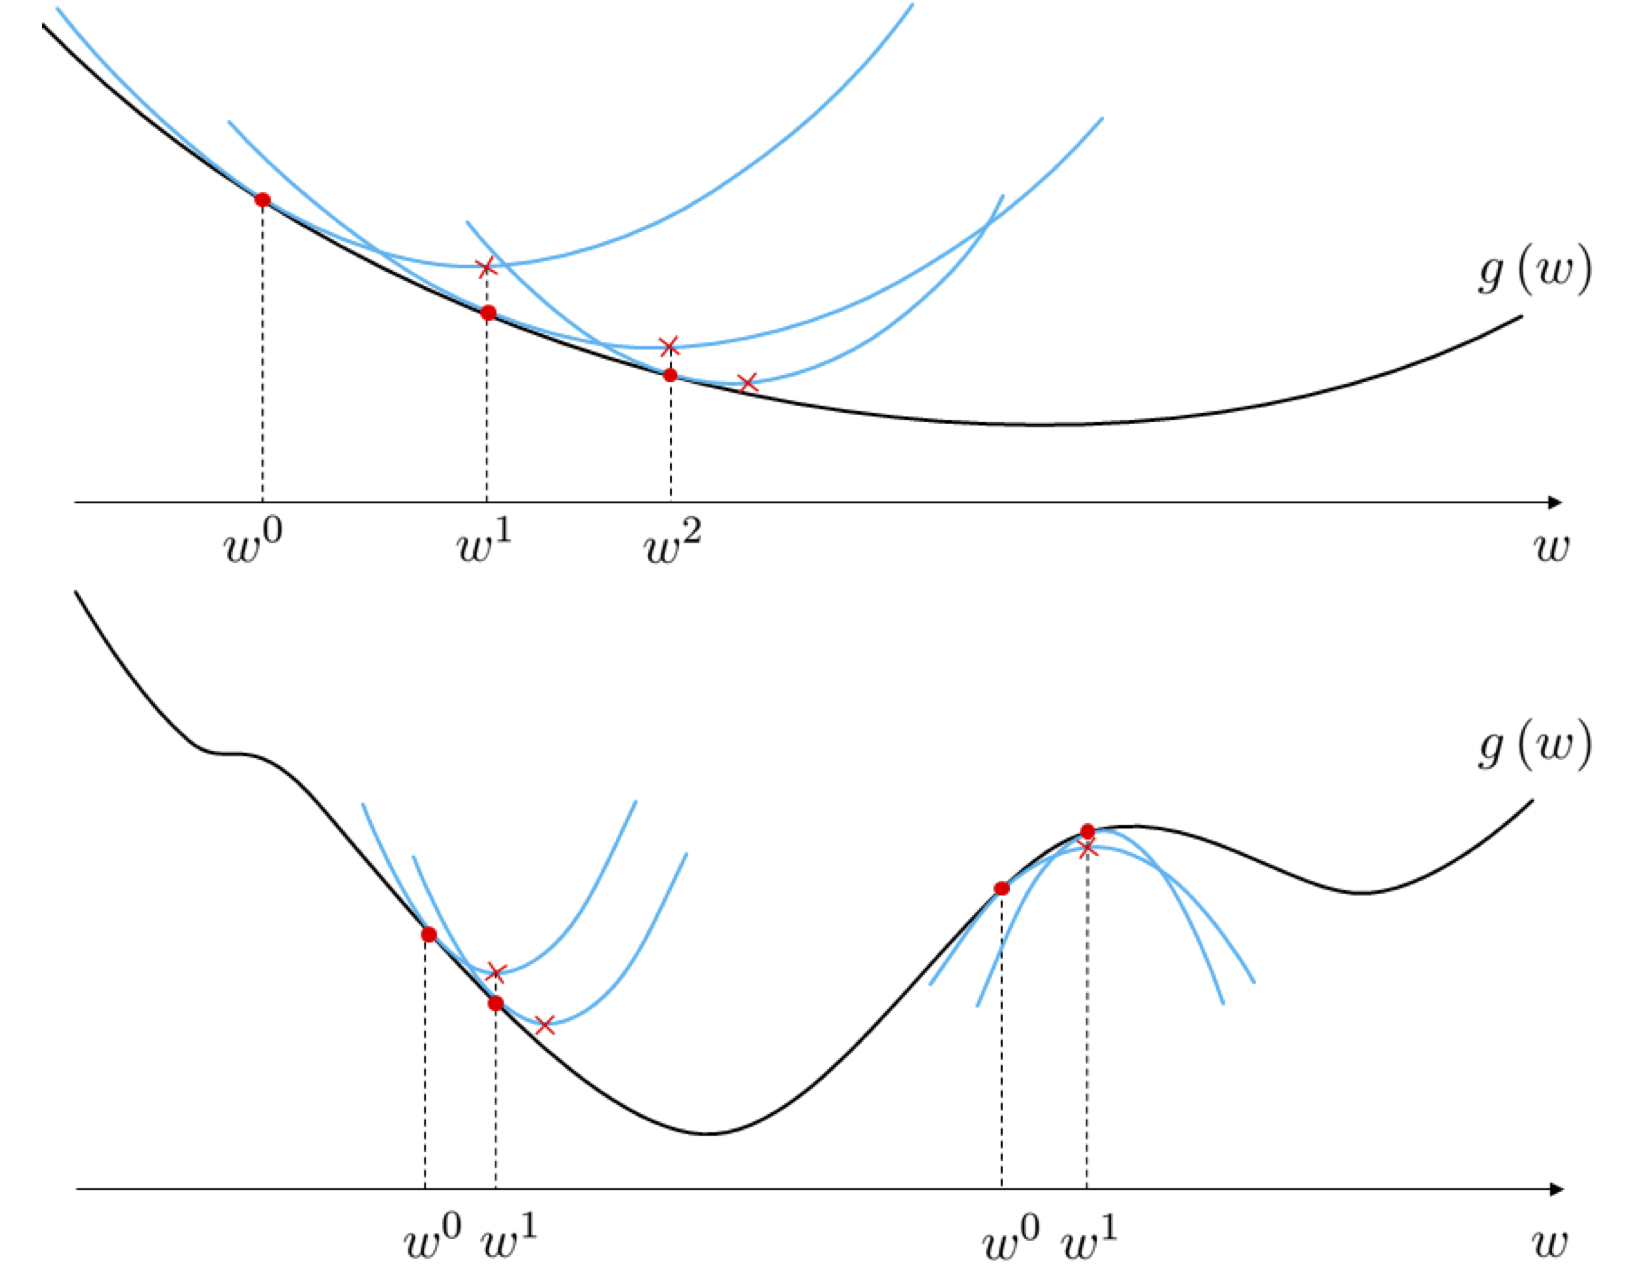

In [15]:
Image(image_path_1, width=800)

<figure>
<figcaption>   
<strong>Figure 1:</strong> <em>Newton's method illustrated. To find a minimum of g Newton's method hops down the stationary points of quadratic approximations generated by g's second order Taylor series. (top panel) For convex functions these quadratic approximations are themselves always convex (upward facing) and so their stationary points are minima, and the sequence leads to a minimum of the original function. (bottom panel) For non-convex functions quadratic approximations can be concave or convex depending on where they are constructed, leading the algorithm to possibly converge to a maximum.</em>  </figcaption> 
</figure>

Note that although in the formula for the stationary point

\begin{equation}
\mathbf{w}^{k} = \mathbf{w}^{k-1} - \left(\nabla^2 g(\mathbf{w}^{k-1})\right)^{-1}\nabla g(\mathbf{w}^{k-1})
\end{equation}

we invert the Hessian - an $N\times N$ matrix, where $N$ is the dimension of the input - in practice this is computationally expensive to implement.  Instead $\mathbf{w}^k$ is typically found via solving the equivalent system of equations 

\begin{equation}
\nabla^2 g\left(\mathbf{w}^{k-1}\right)\mathbf{w} = \nabla^2 g\left(\mathbf{w}^{k-1}\right)\mathbf{w}^{k-1} - \nabla g(\mathbf{w}^{k-1})
\end{equation}

since this is a more efficient calculation.  When more than one solution exists (e.g., if we are in a long narrow half-pipe of a convex function) the *smallest possible solution* is taken - this is typically referred to as the *pseudo-inverse*. 

## Ensuring numerical stability 

Take the single-input Newton step

\begin{equation}
w^{k} = w^{k-1} - \frac{\frac{\mathrm{d}}{\mathrm{d}w}g(w^{k-1})}{\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w^{k-1})}
\end{equation}

Near flat portions of a function both $\frac{\mathrm{d}}{\mathrm{d}w}g(w^{k-1})$ and $\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w^{k-1})$ are both nearly zero valued.  This can cause serious numerical problems since once each (but especially the denominator) shrinks below machine precision the computer interprets $\frac{\frac{\mathrm{d}}{\mathrm{d}w}g(w^{k-1})}{\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w^{k-1})}\approx \frac{0}{0}$.  

One simple and common way to avoid this potential disaster is to simply add a small positive value $\epsilon$ to the second derivative - either when it shrinks below a certain value or for all iterations.  This *regularized* Newton's step looks like the following

\begin{equation}
w^{k} = w^{k-1} - \frac{\frac{\mathrm{d}}{\mathrm{d}w}g(w^{k-1})}{\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w^{k-1}) + \epsilon}
\end{equation}

The value of the *regularization parameter* $\epsilon$ is set by hand to a small positive value (e.g., $10^{-7}$).  Note this is an adjustment made when the function being minimized is known to be convex, since in this case $\frac{\mathrm{d}^2}{\mathrm{d}w^2}g(w) \geq 0$ for all $w$.  

The analogous adjustment for the multi-input case is to add $\epsilon \mathbf{I}_{N\times N}$ - a  $N\times N$ identity matrix scaled by a small positive $\epsilon$ value - to the Hessian matrix.  This gives the completely analogous regularized Newton's step for the multi-input case

\begin{equation}
\mathbf{w}^{k} = \mathbf{w}^{k-1} - \left(\nabla^2 g(\mathbf{w}^{k-1}) + \epsilon \mathbf{I}_{N\times N}\right)^{-1}\nabla g(\mathbf{w}^{k-1})
\end{equation}

Note here that since again the function being minimized is assumed to be convex, adding this to the Hessian means that the matrix $\left(\nabla^2 g(\mathbf{w}^{k-1}) + \epsilon \mathbf{I}_{N\times N}\right)$ is always invertible.  Nonetheless it is virtually always more numerically efficient to compute this update by solving the associated linear system $\left(\nabla^2 g(\mathbf{w}^{k-1}) + \epsilon \mathbf{I}_{N\times N}\right)\mathbf{w} = \left(\nabla^2 g(\mathbf{w}^{k-1}) + \epsilon \mathbf{I}_{N\times N}\right)\mathbf{w}^{k-1} - \nabla g(\mathbf{w}^{k-1})$ for $\mathbf{w}$.

This adjustment is so important and commonplace that we included it in both our formal pseudo-code and implementation below.

Note: while we used a maximum iterations convergence criterion is employed below, the the high computational cost of each Newton step often incentivizes the use of more formal convergence criterion (e.g., halting when the norm of the gradient falls below a pre-defined threshold).  This also often incentivizes the inclusion of checkpoints that measure and/or adjust the progress of a Newton's method run in order to avoid problems near flat areas of a function.  

### Newton's method

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> function $g$, maximum number of steps $K$, initial point $\mathbf{w}^0$, and regularization parameter $\epsilon$ <br/>
    
<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $k=1...K$<br>

<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\mathbf{w}^{k} = \mathbf{w}^{k-1} - \left(\nabla^2 g(\mathbf{w}^{k-1}) + \epsilon \mathbf{I}_{N\times N}\right)^{-1}\nabla g(\mathbf{w}^{k-1})$
<br>
 
<strong>4:</strong>&nbsp; <strong>output:</strong> history of weights $\left\{\mathbf{w}^{k}\right\}_{k=0}^K$ and corresponding function evaluations $\left\{g\left(\mathbf{w}^{k}\right)\right\}_{k=0}^K$ <br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

In [16]:
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breez
from autograd import grad 
from autograd import hessian

# newtons method function - inputs: g (input function), max_its (maximum number of iterations), w (initialization)
def newtons_method(g,max_its,w,**kwargs):
    # compute gradient module using autograd
    gradient = grad(g)
    hess = hessian(g)
    
    # set numericxal stability parameter / regularization parameter
    epsilon = 10**(-7)
    if 'epsilon' in kwargs:
        beta = kwargs['epsilon']

    # run the newtons method loop
    weight_history = [w]           # container for weight history
    cost_history = [g(w)]          # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient and hessian
        grad_eval = gradient(w)
        hess_eval = hess(w)

        # reshape hessian to square matrix for numpy linalg functionality
        hess_eval.shape = (int((np.size(hess_eval))**(0.5)),int((np.size(hess_eval))**(0.5)))
        
        # solve second order system system for weight update
        A = hess_eval + epsilon*np.eye(w.size)
        b = grad_eval
        w = np.linalg.solve(A,np.dot(A,w) - b)
        
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history,cost_history

#### <span style="color:#a50e3e;">Example 5. </span>  Animating Newton's method applied to a convex single-input function

In the next Python cell we animate the process of performing Newton's method to minimize the function

\begin{equation}
g(w) = \frac{1}{50}\left(w^4 + w^2 + 10w \right) + 0.5
\end{equation}

beginning at the point $w = 2.5$ marked as a magenta dot (and corresponding evaluation of the function marked as magenta X). 

Moving the slider from left to right animates each step of the process in stages - the second order approximation is shown in light blue, then its minimum is marked with a magenta dot on the input space, along with the evaluation on the quadratic and function $g$ marked as a magenta and blue X respectively.  As Newton's method continues each step is colored from green - when the method begins - to red as it reaches the maximum number of pre-defined iterations (set here to 5).

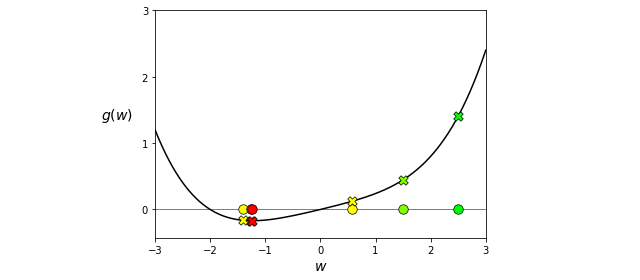

In [17]:
# what function should we play with?  Defined in the next line.
g = lambda w: 1/float(50)*(w**4 + w**2 + 10*w)   # try other functions too!  Like g = lambda w: np.cos(2*w) , g = lambda w: np.sin(5*w) + 0.1*w**2, g = lambda w: np.cos(5*w)*np.sin(w)

# run gradient descent 
w = np.array([2.5]); max_its = 5;
weight_history,cost_history = newtons_method(g,max_its,w)

# animate the process
section_4_4_helpers.animation_visualizer().newtons_method(g,weight_history,savepath=video_path_4,fps=1)

In [18]:
show_video(video_path_4, width=800)

#### <span style="color:#a50e3e;">Example 6. </span>  Minimizing a quadratic function with a single Newton step

Below we apply a single Newton step to completely minimize the quadratic function

\begin{equation}
g(w_1,w_2) = 0.26(w_1^2 + w_2^2) - 0.48w_1w_2
\end{equation}

This can be done with a single step because the second order Taylor series - being a quadratic (local) approximation to a function - of a quadratic function is simply itself, and thus reduces to solving the first order system of a quadratic function (a linear system of equations).  We compare a run of $100$ steps of gradient descent (left panel) with a single Newton step (right panel).

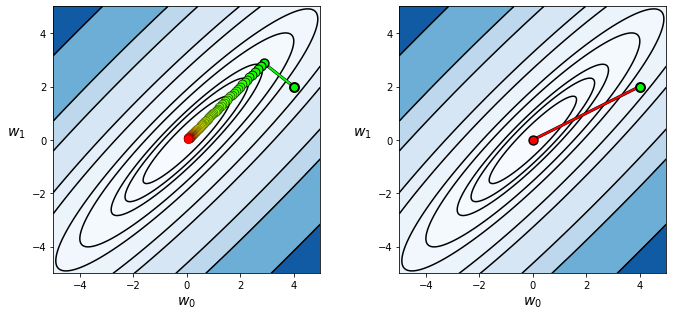

In [19]:
# the Rastrigin function
g = lambda w: (0.26*(w[0]**2 + w[1]**2) - 0.48*w[0]*w[1])[0]

# run gradient descent 
w = np.array([4.0,2.0])[:,np.newaxis]; max_its = 100; alpha_choice = 1;
weight_history_1,cost_history_1 = section_4_4_helpers.gradient_descent(g,alpha_choice,max_its,w)
w = np.array([4.0,2.0])[:,np.newaxis]; max_its = 1;
weight_history_2,cost_history_2 = newtons_method(g,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
section_4_4_helpers.static_visualizer().compare_runs_contour_plots(g,[weight_history_1,weight_history_2],xmin = -5,xmax = 5,ymin = -5,ymax = 5,num_contours = 25)

Indeed this is the same solution identified visually in the plot above.

##  Steplength choices

While we have seen in the derivation of Newton's method that - being a local optimization approach - it does have an steplength parameter $\alpha$ it is implicitly set to $\alpha = 1$ and so appears 'invisible'.  However note that one can explicitly introduce a steplength parameter $\alpha$ and - in principle -  use adjustable methods, e.g., backtracking line search (described the previous Chapter in the context of gradient descent) in order to tune $\alpha$.  Adding a steplength parameter $\alpha$  this explicitly weighted Newton step looks like 

\begin{equation}
\mathbf{w}^{k} = \mathbf{w}^{k-1} - \alpha\left(\nabla^2 g(\mathbf{w}^{k-1})\right)^{-1}\nabla g(\mathbf{w}^{k-1})
\end{equation}

with the standard Newton's method step falling out when $\alpha = 1$. 